## Dataset Description
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.

File descriptions:
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set - contains some comments which are not included in scoring.
- sample_submission.csv - a sample submission file in the correct format
- test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
from pickle import dump, load
import zipfile
import os

from collections import Counter

from nltk.corpus import stopwords
from nltk.probability import FreqDist

from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, concatenate
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

def extract_zip_files(zip_file_path, extract_to_dir):
    # Path to the zip file
    zip_file_path = zip_file_path
    # directory to extract contents
    extract_to_dir = extract_to_dir
    # Extracting the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all contents to the specified directory
            zip_ref.extractall(extract_to_dir)
        print(f"Contents of {zip_file_path} extracted successfully to {extract_to_dir}.")
    except FileNotFoundError:
        print(f"Error: The file {zip_file_path} does not exist.")
    except zipfile.BadZipFile:
        print(f"Error: The file {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
# load doc into memory
def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from words
    tokens = [re_punc.sub('', word) for word in tokens]
    # remove remaining words that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # standardize tokens
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# save a dataset to a file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
# load a clean dataset
def load_output(filename):
    return load(open(filename, 'rb'))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Memory usage in MB

    for col in df.columns:
        col_type = df[col].dtype
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            # Downcast integers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            # Downcast floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        reduction_percent = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage decreased to {end_mem:.2f} MB ({reduction_percent:.1f}% reduction)")

    return df

2025-01-25 18:04:06.905205: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 18:04:06.913542: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 18:04:07.022647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 18:04:07.022756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 18:04:07.032941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Load data:

In [2]:
# extract main file
zip_file_path = 'jigsaw-toxic-comment-classification-challenge.zip'
extract_to_dir = './toxic_files'
extract_zip_files(zip_file_path, extract_to_dir)

Contents of jigsaw-toxic-comment-classification-challenge.zip extracted successfully to ./toxic_files.


In [3]:
# extract training zip file:
zip_file_path = './toxic_files/train.csv.zip'
extract_to_dir = './toxic_files/train_file'
extract_zip_files(zip_file_path, extract_to_dir)

# extract test zip file:
zip_file_path = './toxic_files/test.csv.zip'
extract_to_dir = './toxic_files/test_file'
extract_zip_files(zip_file_path, extract_to_dir)

# extract 
zip_file_path = './toxic_files/test_labels.csv.zip'
extract_to_dir = './toxic_files/test_file'
extract_zip_files(zip_file_path, extract_to_dir)

Contents of ./toxic_files/train.csv.zip extracted successfully to ./toxic_files/train_file.
Contents of ./toxic_files/test.csv.zip extracted successfully to ./toxic_files/test_file.
Contents of ./toxic_files/test_labels.csv.zip extracted successfully to ./toxic_files/test_file.


In [4]:
# load extracted files
train_df = pd.read_csv('./toxic_files/train_file/train.csv', index_col=0)
test_doc = pd.read_csv('./toxic_files/test_file/test.csv')
ytest = pd.read_csv('./toxic_files/test_file/test_labels.csv')

train_df = reduce_mem_usage(train_df)
test_doc = reduce_mem_usage(test_doc)
ytest = reduce_mem_usage(ytest)

train_df.info()

# perform data remediation for the test set:
test_df = pd.merge(test_doc, ytest, on='id', how='left')
test_df.set_index('id', inplace=True)
# remove none informative labels
test_df = test_df[~(test_df == -1).any(axis=1)]
# sumarise data sets:
print('\nData summary:')
print(f'Training dataset: {train_df.shape[0]} rows, {train_df.shape[1]} columns')
print(f'Test dataset: {test_df.shape[0]} rows, {test_df.shape[1]} columns')

# split into input and output:
train_docs, ytrain = train_df['comment_text'], train_df.iloc[:, -6:].values.astype(int)
test_docs, ytest = test_df['comment_text'], test_df.iloc[:, -6:].values.astype(int)

# save files:
train_docs = train_docs.to_frame()
test_docs = test_docs.to_frame()
train_docs.to_csv('train_docs.csv'), test_docs.to_csv('test_docs.csv')
save_dataset([ytrain, ytest], 'output.pkl')

Memory usage decreased to 3.35 MB (65.6% reduction)
Memory usage decreased to 2.34 MB (0.0% reduction)
Memory usage decreased to 2.05 MB (75.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int8  
 2   severe_toxic   159571 non-null  int8  
 3   obscene        159571 non-null  int8  
 4   threat         159571 non-null  int8  
 5   insult         159571 non-null  int8  
 6   identity_hate  159571 non-null  int8  
dtypes: int8(6), object(1)
memory usage: 3.3+ MB

Data summary:
Training dataset: 159571 rows, 7 columns
Test dataset: 63978 rows, 7 columns
Saved: output.pkl


# Analysing most toxic tokens by toxicity type:

In [5]:
class toxicity_analyser(object):
    def __init__(self, df, most_common):
        self.df = df
        self.most_common = most_common
        
    def combine_words(self, word_list):
        all_words = []
        for word in word_list:
            all_words += word
        return all_words
        
    def create_word_cloud(self, col_name):
        df = self.df[self.df[col_name] == 1]
        tokens = df['comment_text'].apply(clean_doc)
        reviewed_tokens = self.combine_words(tokens)
        mostcommon = FreqDist(reviewed_tokens).most_common(self.most_common)
        wordcloud = WordCloud(width=1500, height=800, background_color='white').generate(str(mostcommon))
        fig = plt.figure(figsize=(30,10), facecolor='white')
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Top {self.most_common} Most Common Words', fontsize=25)
        plt.show()

In [6]:
toxicity = toxicity_analyser(train_df, 100)

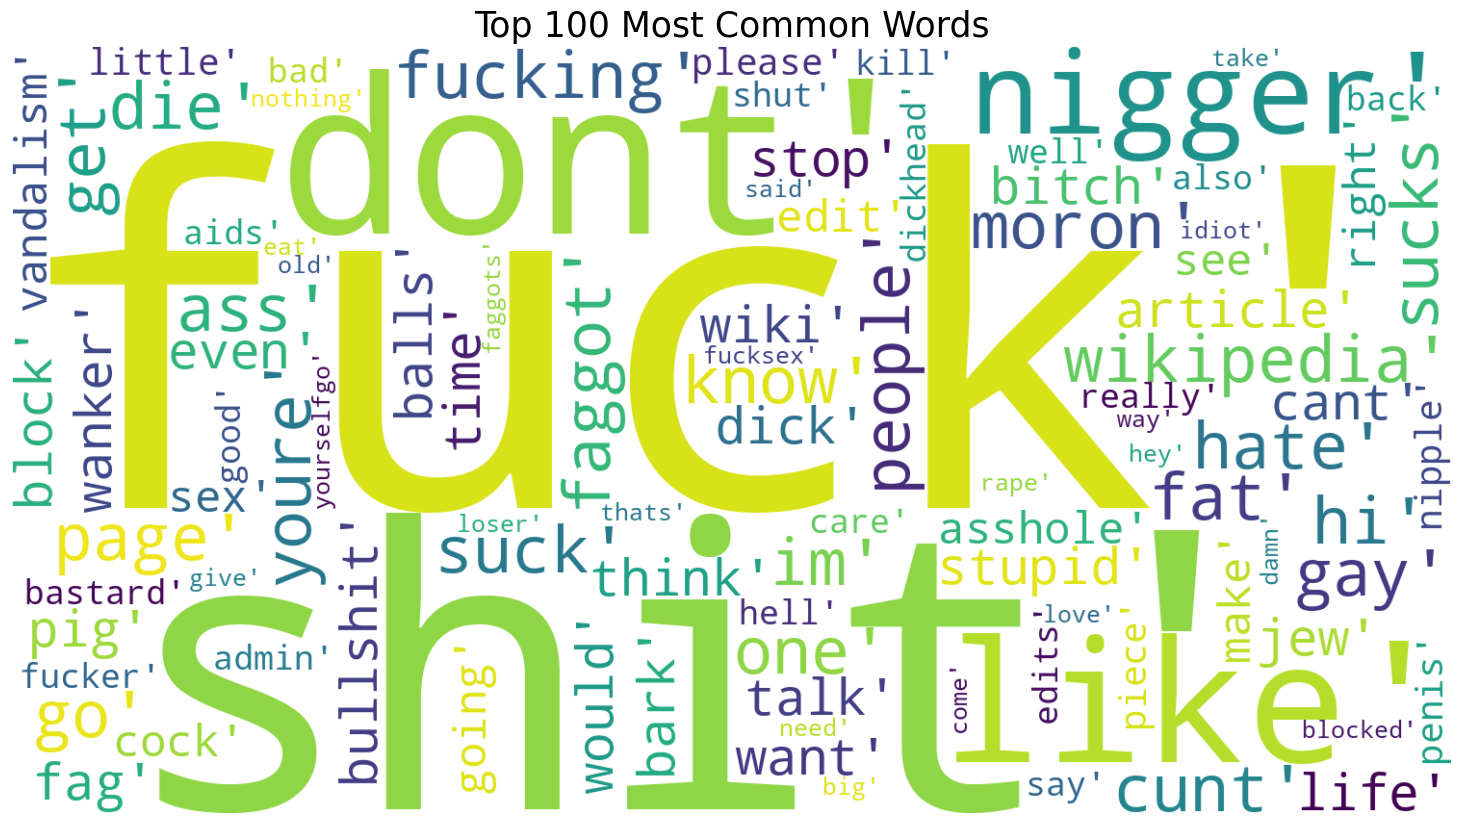

In [7]:
toxicity.create_word_cloud('toxic')

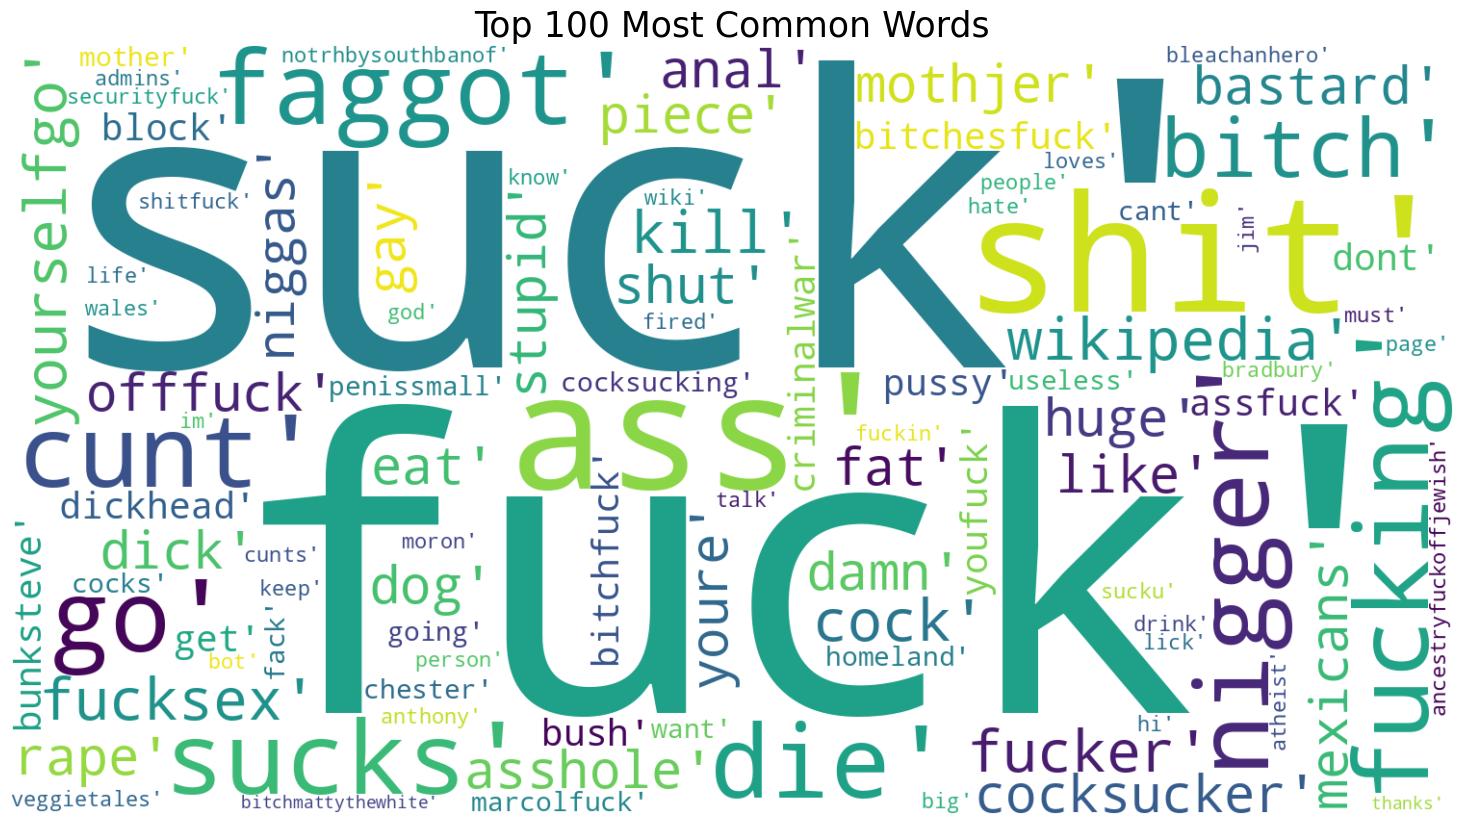

In [8]:
toxicity.create_word_cloud('severe_toxic')

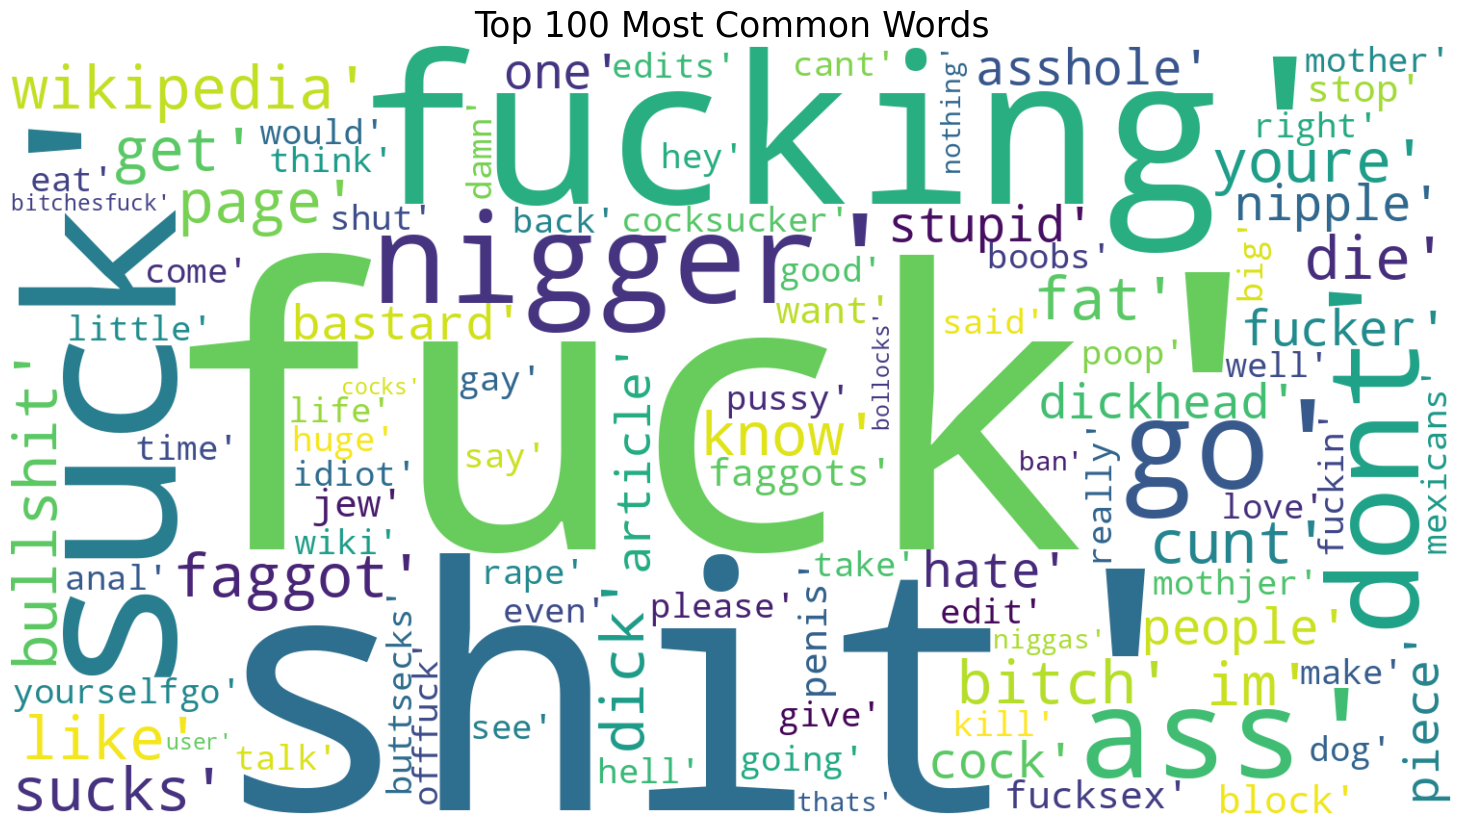

In [9]:
toxicity.create_word_cloud('obscene')

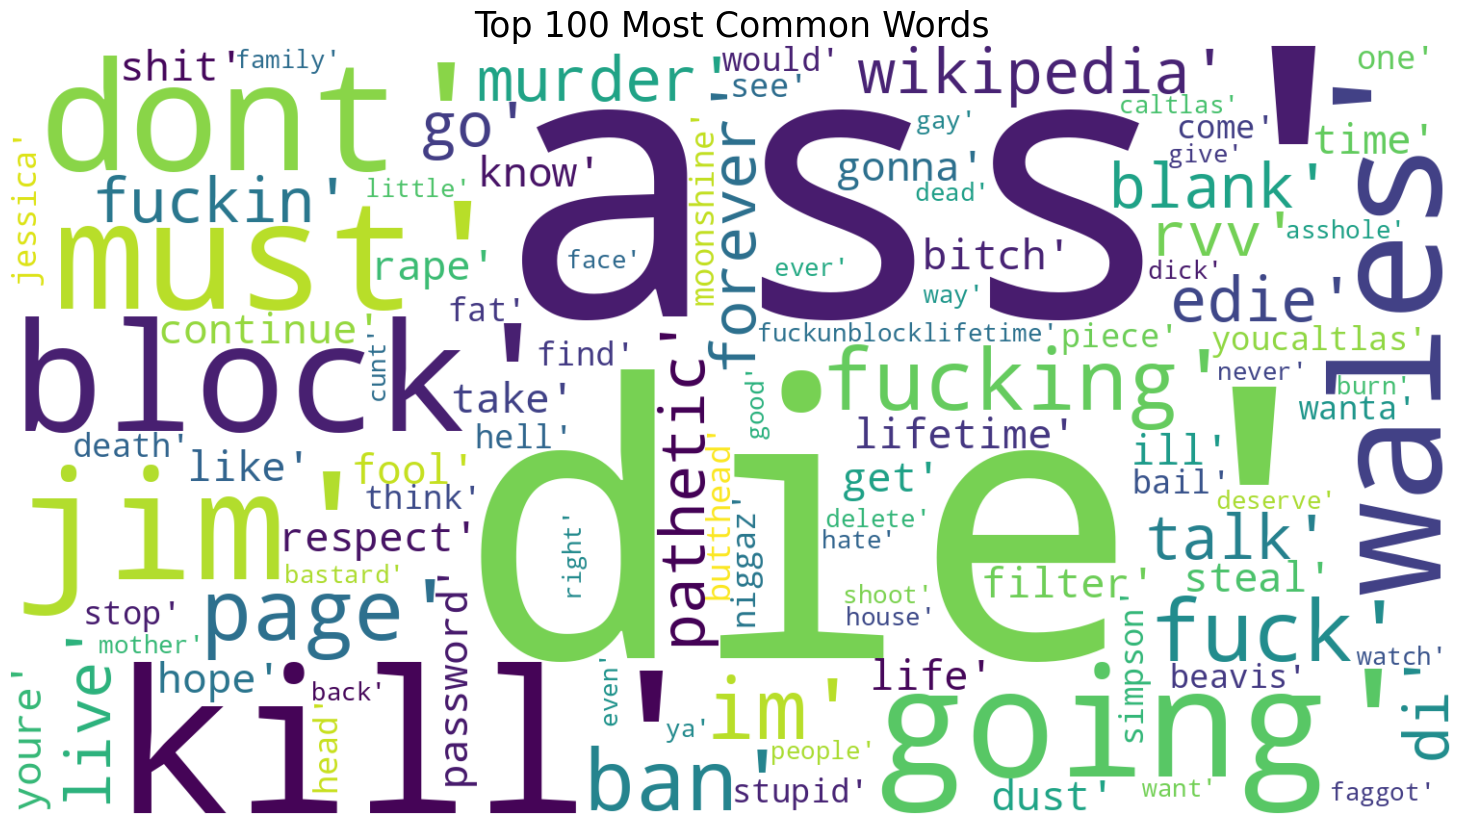

In [10]:
toxicity.create_word_cloud('threat')

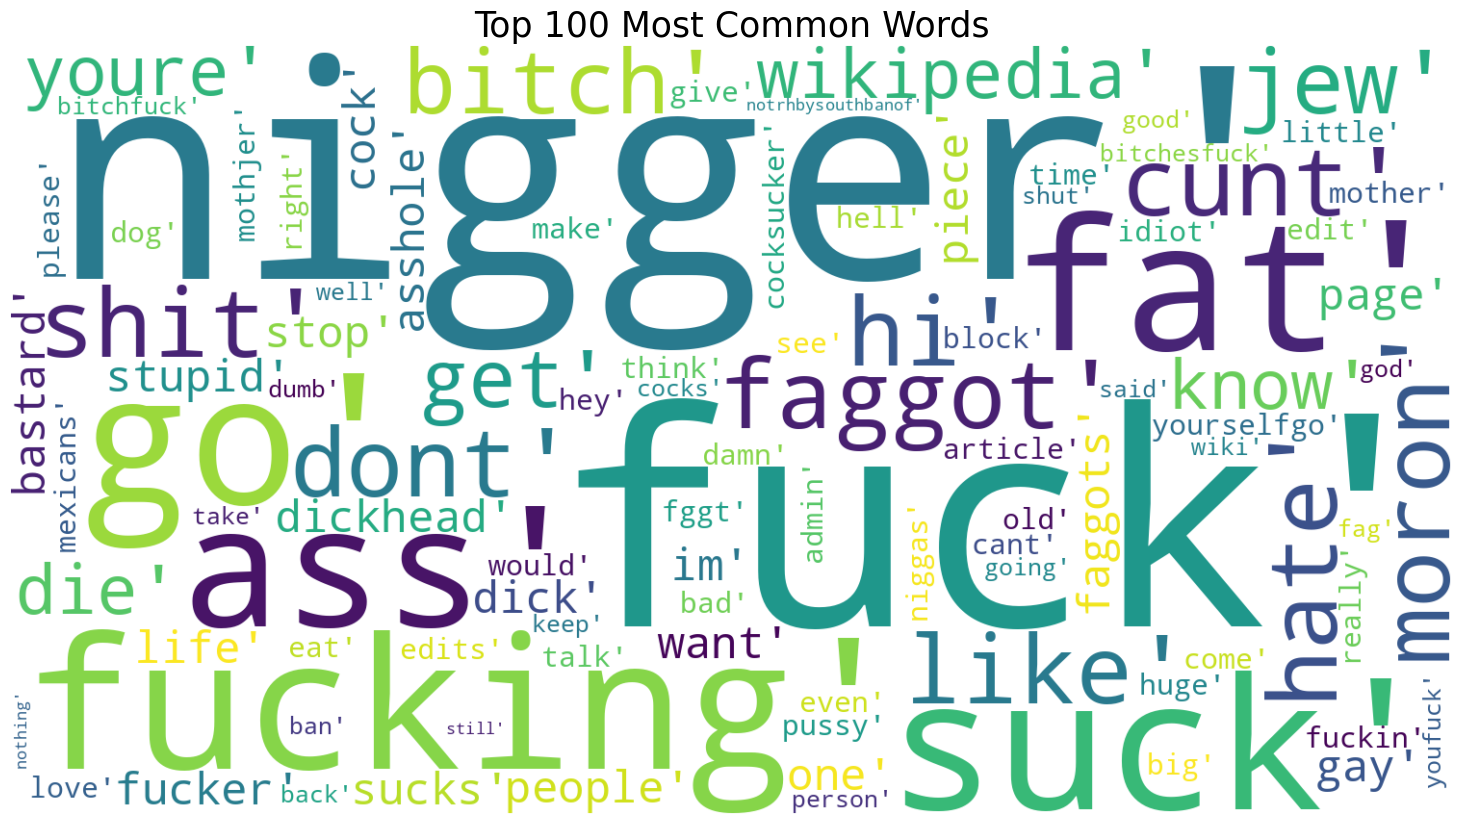

In [11]:
toxicity.create_word_cloud('insult')

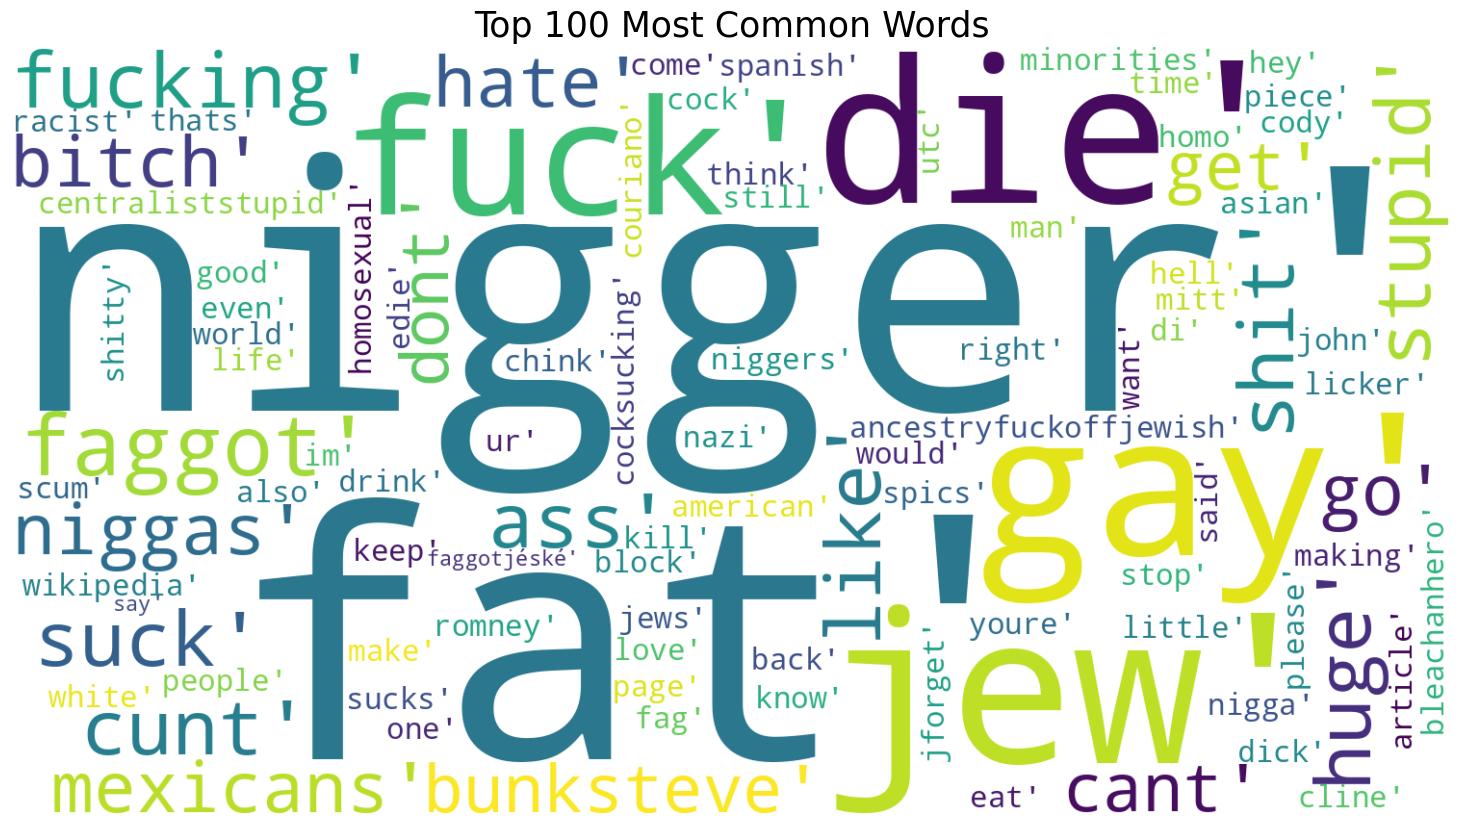

In [12]:
toxicity.create_word_cloud('identity_hate')

# Create Vocabulary:

In [13]:
# add doc to vocabulary
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)
    
# save list to file
def save_list(lines, filename):
    # convert lines into a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close

# define vocab
vocab = Counter()

# add all docs to vocab
add_doc_to_vocab('train_docs.csv', vocab)

# print size of the vocab
print(len(vocab))
# print most common words - overall
print(vocab.most_common(50))

# keep token with a min occurance
min_occurance = 2
tokens = [k for k,c in vocab.items() if c >= min_occurance]
print(len(tokens))

# save token to vocavulary
save_list(tokens, 'vocab.text')

212628
[('article', 55229), ('page', 45521), ('wikipedia', 35279), ('talk', 30801), ('would', 29103), ('one', 27880), ('please', 27658), ('like', 27641), ('dont', 25329), ('see', 21241), ('also', 20064), ('think', 20014), ('know', 18976), ('im', 18126), ('people', 17605), ('articles', 17465), ('edit', 17348), ('use', 16277), ('may', 15419), ('time', 15349), ('even', 13314), ('get', 13216), ('make', 12906), ('good', 12284), ('information', 12054), ('thanks', 12040), ('could', 11765), ('want', 11587), ('sources', 11181), ('way', 11129), ('well', 10976), ('name', 10931), ('pages', 10809), ('deletion', 10729), ('first', 10629), ('help', 10325), ('new', 10265), ('editing', 10154), ('source', 10138), ('need', 10124), ('say', 10055), ('section', 9969), ('go', 9924), ('edits', 9832), ('made', 9552), ('many', 9474), ('user', 9402), ('much', 9399), ('used', 9154), ('really', 9128)]
89282


# Build model: n-gram multihead CNN Model

In [ ]:
# Data generator
class DataGenerator(Sequence):
    def __init__(self, texts, labels, tokenizer, max_length, batch_size=32):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.texts) / self.batch_size))

    def __getitem__(self, idx):
        batch_texts = self.texts[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        encoded_texts = encode_text(self.tokenizer, batch_texts, self.max_length)
        return [encoded_texts] * len(kernels), batch_labels

def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from words
    tokens = [re_punc.sub('', word) for word in tokens]
    # remove remaining words that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # standardize tokens
    tokens = [word.lower() for word in tokens]
    #filter out tokens not in the vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens


# load and clean a dataset
def load_clean_dataset(filename, vocab):
    doc = load_doc(filename)  # Ensure `load_doc` is defined
    tokens = clean_doc(doc, vocab)
    return tokens

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

# Define model
def define_model(vocab_size, length, kernels, embedding_dim=100):
    inputs = []
    combine = []
    for kernel in kernels:
        in_layer = Input(shape=(length,))
        embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(in_layer)
        conv = Conv1D(filters=32, kernel_size=kernel, activation='relu')(embedding)
        drop = Dropout(0.5)(conv)
        pool = MaxPool1D(pool_size=2)(drop)
        flat = Flatten()(pool)
        inputs.append(in_layer)
        combine.append(flat)
    merged = concatenate(combine)
    dense = Dense(100, activation='relu')(merged)
    dense = Dropout(0.5)(dense)
    outputs = Dense(6, activation='softmax')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'roc_auc'])
    model.summary()
    plot_model(model, to_file='n_gram_multihead_cnn_model.png', show_shapes=True)
    return model

# Evaluate model
def evaluate_model(model, Xtrain, ytrain, Xtest, ytest, kernels, n_repeats=5):
    train_generator = DataGenerator(Xtrain, ytrain, tokenizer, length, batch_size=32)
    test_generator = DataGenerator(Xtest, ytest, tokenizer, length, batch_size=32)
    scores = []
    for i in range(1, n_repeats + 1):
        rlp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
        model.fit(train_generator, validation_data=test_generator, epochs=20, verbose=1, callbacks=[rlp, es])
        _, acc = model.evaluate(test_generator, verbose=0)
        if i == 1 or i % 5 == 0:
            print(f'Run {i}: Test Accuracy: {acc * 100:.3f}')
        scores.append(acc)
    mean_score = np.mean(scores)
    print(f'Mean Accuracy: {mean_score * 100:.3f}')
    
# load vocab
vocab_filename = 'vocab.text'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
    
# Load vocab
vocab_filename = 'vocab.text'
vocab = load_doc(vocab_filename)  # Ensure `load_doc` is defined
vocab = set(vocab.split())

# Load datasets
ytrain, ytest = load_output('output.pkl')  # Ensure `load_output` is defined

# Clean training and test docs
trainLines = train_docs['comment_text'].apply(lambda x: clean_doc(x, vocab)).astype(str)
testLines = test_docs['comment_text'].apply(lambda x: clean_doc(x, vocab)).astype(str)

# Tokenize and encode datasets
tokenizer = create_tokenizer(trainLines)
vocab_size = len(tokenizer.word_index) + 1
length = max_length(trainLines)
print(f'Vocabulary size: {vocab_size}')
print(f'Maximum document length: {length}')

# Define and evaluate model
kernels = [2, 3]
model = define_model(vocab_size, length, kernels)
evaluate_model(model, trainLines.tolist(), ytrain, testLines.tolist(), ytest, kernels)

In [ ]:
doc = "some string"  # This overwrites the `clean_doc` function
clean_doc(doc, vocab) 